In [2]:
import torch
import csv
import numpy as np
import matplotlib.pyplot as plt
import os
import gc

from torch.utils.data import Dataset    
from torch.utils.data import DataLoader
import torch.nn as nn

from sklearn.utils import class_weight
from sklearn import metrics

DATASET = 'cryptobench'
DATA_PATH = f'/home/skrhakv/cryptic-nn/data/{DATASET}'
ESM_EMBEDDINGS_PATH = f'{DATA_PATH}/embeddings'
DISTANCE_MATRICES_PATH = f'{DATA_PATH}/distance-matrices'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
POSITIVE_DISTANCE_THRESHOLD = 15
NEGATIVE_DISTANCE_THRESHOLD = 10

def process_sequence_dataset(annotation_path, embeddings_path, distance_matrices_path, perform_assertions=True):
    Xs = {}
    Ys = {}
    idx = {}

    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            if perform_assertions:
                sequence = row[4]

            if row[3] == '':
                continue
            
            assert id not in Xs
            assert id not in Ys
            Xs[id] = []
            Ys[id] = []
            idx[id] = []

            # load the precomputed embedding
            filename = id + '.npy'
            embedding = np.load(f'{embeddings_path}/{filename}')
            
            # load the distance matrix
            distance_matrix = np.load(f'{distance_matrices_path}/{id}.npy')

            negative_examples_indices = set()
            binding_residues_indices = [int(residue[1:]) for residue in row[3].split(' ')]
            
            for (aa, residue_idx) in [(residue[0], int(residue[1:])) for residue in row[3].split(' ')]:
                if perform_assertions:
                    assert sequence[residue_idx] == aa
                # check if the distance of the residue to all other residues is less than the threshold
                close_residues_indices = np.where(distance_matrix[residue_idx] < POSITIVE_DISTANCE_THRESHOLD)[0]
                # get residues that are close to the current residue and are binding residues
                close_binding_residues_indices = np.intersect1d(close_residues_indices, binding_residues_indices)
                
                # create embedding by aggregating the embeddings of the close binding residues
                concatenated_embedding = np.concatenate((embedding[residue_idx], np.mean(embedding[close_binding_residues_indices], axis=0)))
                Xs[id].append(concatenated_embedding)
                Ys[id].append(1) # positive example
                idx[id].append(residue_idx)
                
                # Let's get negative examples:
                # add those that are really close to the binding residues (i.e. within NEGATIVE_DISTANCE_THRESHOLD) but are not binding residues
                really_close_residues_indices = np.where(distance_matrix[residue_idx] < NEGATIVE_DISTANCE_THRESHOLD)[0]
                # add non-binding residues to the list of negatives (that's the exclusive left join of really_close_residues_indices and binding_residues_indices)
                negative_examples_indices.update(set(list(really_close_residues_indices)) - set(list(binding_residues_indices)))

            # add negative examples - create the embeddings 
            for residue_idx in negative_examples_indices:
                close_residues_indices = np.where(distance_matrix[residue_idx] < POSITIVE_DISTANCE_THRESHOLD)[0]
                close_binding_residues_indices = np.intersect1d(close_residues_indices, binding_residues_indices)

                # create embedding 
                concatenated_embedding = np.concatenate((embedding[residue_idx], np.mean(embedding[close_binding_residues_indices], axis=0)))
                Xs[id].append(concatenated_embedding)
                Ys[id].append(0) # negative example
                idx[id].append(residue_idx)

    return Xs, Ys, idx

class SmoothnessClassifierDataset(Dataset):
    def __init__(self, _Xs, _Ys):
        _Xs_list = []
        _Ys_list = []

        for key, _ in _Xs.items():
            # print(f'Processing {key} ...')
            _Xs_list.append(_Xs[key])
            _Ys_list.append(_Ys[key])
        del _Xs, _Ys
        gc.collect()
        
        print('Concatenating ...')
        Xs_list = np.concatenate(_Xs_list, axis=0)
        Ys_list = np.concatenate(_Ys_list, axis=0)

        print('Converting to torch tensor ...')
        self.Xs = torch.tensor(Xs_list, dtype=torch.float32)
        self.Ys = torch.tensor(Ys_list, dtype=torch.int64)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y


## Use validation set
Use one of the training folds as a validation set:
```
/home/skrhakv/cryptic-nn/src/fine-tuning/val.txt
/home/skrhakv/cryptic-nn/src/fine-tuning/train.txt
```

In [4]:
Xs_train, Ys_train, _ = process_sequence_dataset(f'/home/skrhakv/cryptic-nn/src/fine-tuning/train.txt', ESM_EMBEDDINGS_PATH, DISTANCE_MATRICES_PATH)
train_dataset = SmoothnessClassifierDataset(Xs_train, Ys_train)

Xs_val, Ys_val, idx_val = process_sequence_dataset(f'/home/skrhakv/cryptic-nn/src/fine-tuning/val.txt', ESM_EMBEDDINGS_PATH, DISTANCE_MATRICES_PATH)
val_dataset = SmoothnessClassifierDataset(Xs_val, Ys_val)

Concatenating ...
Converting to torch tensor ...
Concatenating ...
Converting to torch tensor ...


In [ ]:
DECISION_THRESHOLD = 0.5
DROPOUT = 0.3
LAYER_WIDTH = 256
ESM2_DIM  = 2560 * 2

class CryptoBenchClassifier(nn.Module):
    def __init__(self, dim=LAYER_WIDTH, dropout=DROPOUT):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=ESM2_DIM, out_features=dim)
        self.dropout1 = nn.Dropout(dropout)

        self.layer_2 = nn.Linear(in_features=dim, out_features=dim)
        self.dropout2 = nn.Dropout(dropout)

        self.layer_3 = nn.Linear(in_features=dim, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.dropout2(self.relu(self.layer_2(self.dropout1(self.relu(self.layer_1(x)))))))


def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

torch.manual_seed(42)

def train(model, optimizer, epochs, batch_size, train_dataset, test_dataset, validation=False, early_stopping_patience=None, print_stuff=True):
    model = model.to(device)

    # Create an optimizer
    _, y_train = train_dataset[:]
    X_test, y_test, = test_dataset[:]

    # compute class weights (because the dataset is heavily imbalanced)
    class_weights = compute_class_weights(y_train.numpy()).to(device)
    if print_stuff:
        print(f'Class weights: ', class_weights)
    # BCEWithLogitsLoss - sigmoid is already built-in!

    loss_fn = nn.BCEWithLogitsLoss(pos_weight=2 * class_weights[1])

    X_test, y_test = X_test.to(device), y_test.to(device).float()

    train_losses, test_losses = [], []

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    best_f1, best_mcc, best_acc, best_auprc, best_auc, best_epoch = 0, 0, 0, 0, 0, 0
    best_test_loss = float('inf')
    early_stopping_counter = 0
    for epoch in range(epochs):
        #
        # TEST
        #
        model.eval()
        with torch.inference_mode():

            test_logits = model(X_test).squeeze()
            
            test_loss = loss_fn(test_logits,
                                y_test)
            test_losses.append(test_loss.cpu().detach().numpy())

            test_pred = (torch.sigmoid(test_logits)>DECISION_THRESHOLD).float()

            # compute metrics on test dataset
            test_acc = accuracy_fn(y_true=y_test,
                                   y_pred=test_pred)
            
            fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())

            f1 = metrics.f1_score(y_test.cpu().numpy(), test_pred.cpu().numpy(), average='weighted')

            precision, recall, thresholds = metrics.precision_recall_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
            auprc = metrics.auc(recall, precision)
            if auprc > best_auprc:
                best_test_loss = test_loss
                best_f1, best_mcc, best_acc, best_auprc, best_auc, best_epoch = f1, mcc, test_acc, auprc, roc_auc, epoch - 1
            elif early_stopping_patience is not None:
                early_stopping_counter += 1
                if early_stopping_counter >= early_stopping_patience:
                    break
        #
        # TRAIN
        #
        batch_losses = []
        for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).float()

            model.train()

            y_logits = model(x_batch).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss = loss_fn(y_logits,
                           y_batch)
            acc = accuracy_fn(y_true=y_batch,
                              y_pred=y_pred)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            batch_losses.append(loss.cpu().detach().numpy())

        train_losses.append(sum(batch_losses) / len(batch_losses))
        #if epoch % 10 == 0:
        if print_stuff:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc:.4f}, MCC: {mcc:.4f}, F1: {f1:.4f}, AUPRC: {auprc:.4f}, sum: {sum(test_pred)}")

    if print_stuff:
        plt.plot(train_losses,label="train loss over epochs")
        plt.plot(test_losses,label="test loss over epochs")
        plt.legend()
        plt.show()

        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

    if not validation:
        for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            test_pred = (torch.sigmoid(test_logits)>i).float()
            test_acc = accuracy_fn(y_true=y_test,
                                    y_pred=test_pred)
            mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
            f1 = metrics.f1_score(y_test.cpu().numpy(), test_pred.cpu().numpy(), average='weighted')
            print(f'THRESHOLD: {i} | F1: {f1:.4f} | MCC: {mcc:.4f} | Test acc: {test_acc:.2f}%')
        return fpr, tpr, roc_auc
    else:
        return best_f1, best_mcc, best_acc, best_auprc, best_auc, best_epoch

In [31]:
EPOCHS = 150

best_dim, best_dropout, best_lr, best_auprc = 0, 0, 0, 0
for dim in [256, 512, 1024, 2048]:
    for dropout in [0.1, 0.3, 0.5]:
        for learning_rate in [0.00001, 0.0001, 0.001]:
            model_3 = CryptoBenchClassifier(dim=dim, dropout=dropout).to(device)
            optimizer = torch.optim.AdamW(params=model_3.parameters(),
                                        lr=learning_rate)

            f1, mcc, acc, auprc, auc, epoch = train(model_3, optimizer, epochs=EPOCHS, batch_size=2048, 
                  train_dataset=train_dataset, test_dataset=val_dataset, validation=True, early_stopping_patience=10, print_stuff=False)
            
            if auprc > best_auprc:
                print(f'New best model found! dim={dim}, dropout={dropout}, lr={learning_rate} | F1: {f1:.4f} | MCC: {mcc:.4f} | Acc: {acc:.2f}% | AUPRC: {auprc:.4f} | AUC: {auc:.4f} | Epoch: {epoch}')
                best_auprc, best_dim, best_dropout, best_lr = auprc, dim, dropout, learning_rate
    

New best model found! dim=256, dropout=0.1, lr=1e-05 | F1: 0.7768 | MCC: 0.4435 | Acc: 75.30% | AUPRC: 0.5738 | AUC: 0.8516 | Epoch: 106
New best model found! dim=256, dropout=0.1, lr=0.0001 | F1: 0.7906 | MCC: 0.4606 | Acc: 76.96% | AUPRC: 0.5923 | AUC: 0.8578 | Epoch: 26
New best model found! dim=256, dropout=0.1, lr=0.001 | F1: 0.8332 | MCC: 0.4857 | Acc: 82.68% | AUPRC: 0.6227 | AUC: 0.8691 | Epoch: 14
New best model found! dim=512, dropout=0.3, lr=0.001 | F1: 0.8168 | MCC: 0.4826 | Acc: 80.30% | AUPRC: 0.6271 | AUC: 0.8695 | Epoch: 7
New best model found! dim=512, dropout=0.5, lr=0.001 | F1: 0.8410 | MCC: 0.5021 | Acc: 83.63% | AUPRC: 0.6335 | AUC: 0.8759 | Epoch: 17
New best model found! dim=1024, dropout=0.5, lr=0.0001 | F1: 0.8423 | MCC: 0.4924 | Acc: 84.09% | AUPRC: 0.6391 | AUC: 0.8759 | Epoch: 32
New best model found! dim=2048, dropout=0.3, lr=0.0001 | F1: 0.8438 | MCC: 0.5028 | Acc: 84.10% | AUPRC: 0.6434 | AUC: 0.8780 | Epoch: 26
New best model found! dim=2048, dropout=0.5

New best model found! batch_size=256 | F1: 0.8322 | MCC: 0.5151 | Acc: 82.10% | AUPRC: 0.6485 | AUC: 0.8830 | Epoch: 17
New best model found! batch_size=512 | F1: 0.8355 | MCC: 0.5206 | Acc: 82.51% | AUPRC: 0.6534 | AUC: 0.8835 | Epoch: 19
Class weights:  tensor([0.6203, 2.5774], device='cuda:0')
Epoch: 0 | Loss: 0.81808, Accuracy: 39.63% | Test loss: 1.23911, AUC: 0.5226, MCC: 0.0189, F1: 0.4358, AUPRC: 0.2018, sum: 11810.0
Epoch: 1 | Loss: 1.10038, Accuracy: 69.11% | Test loss: 0.90494, AUC: 0.8258, MCC: 0.3895, F1: 0.7241, AUPRC: 0.4962, sum: 7594.0
Epoch: 2 | Loss: 0.65449, Accuracy: 66.02% | Test loss: 0.88400, AUC: 0.8471, MCC: 0.3930, F1: 0.6965, AUPRC: 0.5616, sum: 8534.0
Epoch: 3 | Loss: 0.30488, Accuracy: 75.68% | Test loss: 0.84810, AUC: 0.8559, MCC: 0.4527, F1: 0.7802, AUPRC: 0.5814, sum: 6284.0
Epoch: 4 | Loss: 0.41205, Accuracy: 81.05% | Test loss: 0.90090, AUC: 0.8638, MCC: 0.4783, F1: 0.8218, AUPRC: 0.5982, sum: 4646.0
Epoch: 5 | Loss: 0.34306, Accuracy: 78.21% | Test l

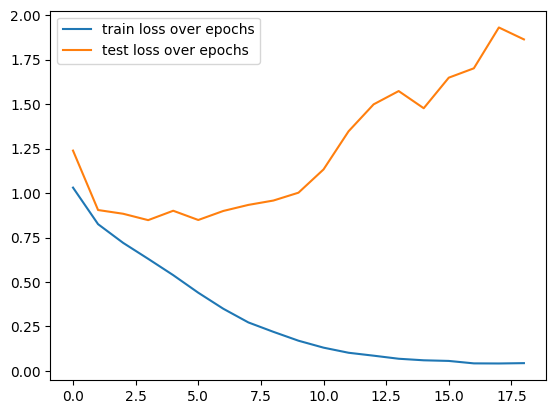

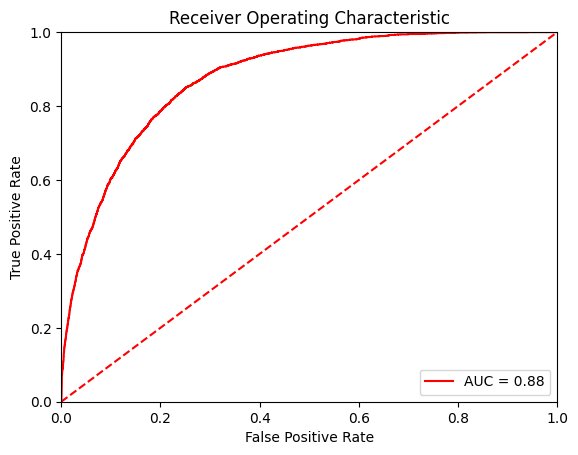

THRESHOLD: 0.1 | F1: 0.8126 | MCC: 0.4958 | Test acc: 79.60%
THRESHOLD: 0.2 | F1: 0.8237 | MCC: 0.4979 | Test acc: 81.09%
THRESHOLD: 0.3 | F1: 0.8310 | MCC: 0.5019 | Test acc: 82.10%
THRESHOLD: 0.4 | F1: 0.8360 | MCC: 0.5029 | Test acc: 82.82%
THRESHOLD: 0.5 | F1: 0.8392 | MCC: 0.5013 | Test acc: 83.36%
THRESHOLD: 0.6 | F1: 0.8418 | MCC: 0.4985 | Test acc: 83.86%
THRESHOLD: 0.7 | F1: 0.8445 | MCC: 0.4976 | Test acc: 84.37%
THRESHOLD: 0.8 | F1: 0.8442 | MCC: 0.4871 | Test acc: 84.64%
THRESHOLD: 0.9 | F1: 0.8416 | MCC: 0.4694 | Test acc: 84.90%


(array([0.00000000e+00, 0.00000000e+00, 2.83647710e-04, ...,
        9.41426748e-01, 9.41426748e-01, 1.00000000e+00]),
 array([0.        , 0.00272232, 0.00514217, ..., 0.99969752, 1.        ,
        1.        ]),
 0.8772499415073121)

In [19]:
best_batch_size, best_epochs, best_auprc = 0, 0, 0
for batch_size in [256, 512, 1024, 2048, 4096]:
    model_3 = CryptoBenchClassifier(dim=best_dim, dropout=best_dropout).to(device)
    optimizer = torch.optim.AdamW(params=model_3.parameters(),
                                lr=best_lr)

    f1, mcc, acc, auprc, auc, epoch = train(model_3, optimizer, epochs=EPOCHS, batch_size=batch_size, 
            train_dataset=train_dataset, test_dataset=val_dataset, validation=True, early_stopping_patience=10, print_stuff=False)

    if auprc > best_auprc:
        print(f'New best model found! batch_size={batch_size} | F1: {f1:.4f} | MCC: {mcc:.4f} | Acc: {acc:.2f}% | AUPRC: {auprc:.4f} | AUC: {auc:.4f} | Epoch: {epoch}')
        best_batch_size = batch_size
        best_epochs = epoch
        best_auprc = auprc

# find DECISION threshold:
model_3 = CryptoBenchClassifier(dim=best_dim, dropout=best_dropout).to(device)
optimizer = torch.optim.AdamW(params=model_3.parameters(),
                            lr=best_lr)

train(model_3, optimizer, epochs=best_epochs, batch_size=best_batch_size, 
        train_dataset=train_dataset, test_dataset=val_dataset)

### Setting `DECISION_THRESHOLD` variable
Based on MCC, the decision threshold should be set at 0.4 `DECISION_THRESHOLD=0.5`:
```
THRESHOLD: 0.4 | F1: 0.8360 | MCC: 0.5029 | Test acc: 82.82%
```

In [20]:
DECISION_THRESHOLD = 0.4

## Run on full TRAIN set
Use parameters found in the previous validation runs.

Concatenating ...
Converting to torch tensor ...
Concatenating ...
Converting to torch tensor ...
Class weights:  tensor([0.6196, 2.5911], device='cuda:0')
Epoch: 0 | Loss: 0.98464, Accuracy: 18.96% | Test loss: 1.23979, AUC: 0.5123, MCC: 0.0000, F1: 0.0605, AUPRC: 0.1938, sum: 16654.0
Epoch: 1 | Loss: 1.23772, Accuracy: 53.59% | Test loss: 0.91111, AUC: 0.8501, MCC: 0.3315, F1: 0.5722, AUPRC: 0.5496, sum: 10705.0
Epoch: 2 | Loss: 0.74264, Accuracy: 63.52% | Test loss: 0.81914, AUC: 0.8711, MCC: 0.3981, F1: 0.6728, AUPRC: 0.6078, sum: 8878.0
Epoch: 3 | Loss: 0.55789, Accuracy: 70.89% | Test loss: 0.74990, AUC: 0.8862, MCC: 0.4569, F1: 0.7403, AUPRC: 0.6489, sum: 7504.0
Epoch: 4 | Loss: 0.62176, Accuracy: 76.57% | Test loss: 0.74769, AUC: 0.8911, MCC: 0.5006, F1: 0.7892, AUPRC: 0.6574, sum: 6306.0
Epoch: 5 | Loss: 0.36206, Accuracy: 76.34% | Test loss: 0.74814, AUC: 0.8955, MCC: 0.4982, F1: 0.7873, AUPRC: 0.6728, sum: 6350.0
Epoch: 6 | Loss: 0.36785, Accuracy: 74.55% | Test loss: 0.7703

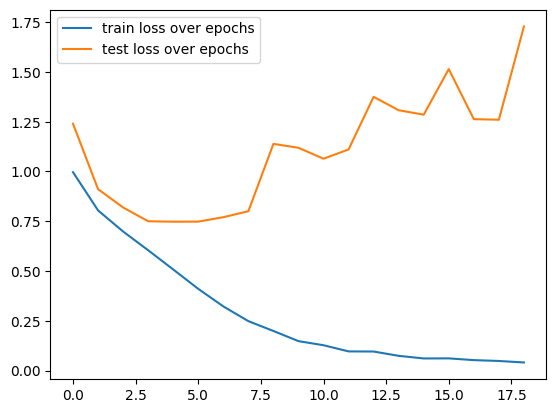

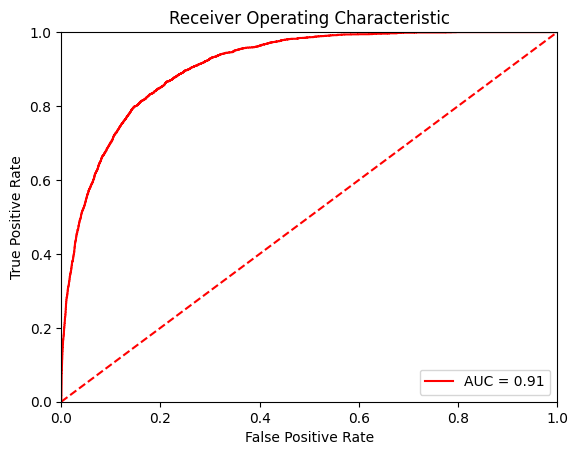

THRESHOLD: 0.1 | F1: 0.8561 | MCC: 0.5751 | Test acc: 84.80%
THRESHOLD: 0.2 | F1: 0.8633 | MCC: 0.5761 | Test acc: 85.85%
THRESHOLD: 0.3 | F1: 0.8663 | MCC: 0.5748 | Test acc: 86.37%
THRESHOLD: 0.4 | F1: 0.8688 | MCC: 0.5757 | Test acc: 86.80%
THRESHOLD: 0.5 | F1: 0.8698 | MCC: 0.5737 | Test acc: 87.06%
THRESHOLD: 0.6 | F1: 0.8693 | MCC: 0.5679 | Test acc: 87.19%
THRESHOLD: 0.7 | F1: 0.8683 | MCC: 0.5615 | Test acc: 87.30%
THRESHOLD: 0.8 | F1: 0.8667 | MCC: 0.5545 | Test acc: 87.37%
THRESHOLD: 0.9 | F1: 0.8624 | MCC: 0.5410 | Test acc: 87.32%


In [21]:
Xs_train, Ys_train, _ = process_sequence_dataset(f'/home/skrhakv/cryptic-nn/data/cryptobench/train.txt', ESM_EMBEDDINGS_PATH, DISTANCE_MATRICES_PATH)
train_dataset = SmoothnessClassifierDataset(Xs_train, Ys_train)

Xs_test, Ys_test, idx_test = process_sequence_dataset(f'/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', ESM_EMBEDDINGS_PATH, DISTANCE_MATRICES_PATH)
test_dataset = SmoothnessClassifierDataset(Xs_test, Ys_test)

model_3 = CryptoBenchClassifier(dim=best_dim, dropout=best_dropout).to(device)
optimizer = torch.optim.AdamW(params=model_3.parameters(),
                            lr=best_lr)

fpr_3, tpr_3, roc_auc_3 = train(model_3, optimizer, epochs=best_epochs, batch_size=best_batch_size, 
      train_dataset=train_dataset, test_dataset=test_dataset)

## Save the model

In [22]:
OUTPUT_PATH = '/home/skrhakv/cryptoshow-analysis/data/C-optimize-smoother/smoother.pt'
torch.save(model_3, OUTPUT_PATH)

# Try on scPDB
Try to retrain the smoother on scPDB dataset and evaluate the difference.

3bxo2
2eju1
1sc61
1x8v1
4ktt1
1s1u1
2p6d1
3s1c1
4emt1
1mc11
1lik2
4rx61
4l2z1
3kjs4
1q4x1
4iei1
3fmh1
3eon1
4eym1
3blo1
4hsu1
1mei1
3gb21
4i9z1
2qa21
3mw96
3sw12
5g532
3ia44
2o2u1
1z7e7
2xe81
1txz1
4ev01
1zzq3
1e661
4iui1
1bp61
5exd2
4aj21
2fdp2
2vv91
1xjn6
3dme1
4jc51
4wuo2
3rzp3
2gmv2
4dcv1
4bz73
4bls2
3g511
1rkp1
4mm71
1ixe2
1gwj1
1u5a1
1to91
1zm74
3clb2
1mp53
3bl71
1zy52
4erw1
1bjq6
4i1w1
4aoj3
1kb92
1z1f1
4qec2
3uax1
1p0y3
3mb91
1u8x1
4zme2
5jad1
1trb1
3cty1
3qyy2
3lzs1
2chx1
3oxk1
3p706
3ruq3
1xm11
2dy91
4jbo1
3fln1
2wzv2
4fkq1
4ajb1
2uxp2
4lrz1
2xj91
2rc52
5fuv1
4yct1
3g7j1
3uko2
2hma1
2cbq8
1ja02
2z1q1
2pqj3
3fkl1
3eym1
2q7h1
4hvx1
3rba1
3nhx1
2j7y1
1nvq2
4itf1
3w2l2
3uel1
1xs71
1fcb2
3pzc1
1buc2
4qly2
4cvl1
1ny52
4coj2
4jv41
2a191
4eso3
4gvs1
2iei2
2fut2
3irh3
4a9y1
1ooq1
2vts1
2dw02
2a1n1
4f7j1
2yyi1
2v161
4bby2
3zc33
3zxz1
4ihl1
4k431
1fdt1
1kl21
4fak1
3of21
2gew1
4dgn1
1h851
4bdg1
1u9q1
4kq61
3fwf2
1h362
2jf62
1gm71
2rg51
2vr11
2pg02
1ody1
2dbr2
4qnu7
3gz31
2yfe2
3nbv1
2xne

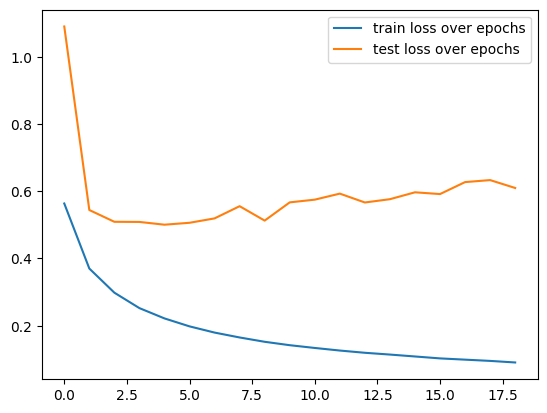

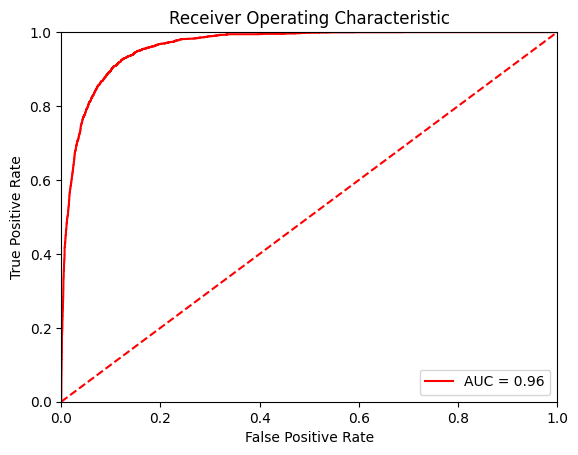

THRESHOLD: 0.1 | F1: 0.8921 | MCC: 0.7024 | Test acc: 88.45%
THRESHOLD: 0.2 | F1: 0.9014 | MCC: 0.7165 | Test acc: 89.56%
THRESHOLD: 0.3 | F1: 0.9062 | MCC: 0.7230 | Test acc: 90.16%
THRESHOLD: 0.4 | F1: 0.9094 | MCC: 0.7271 | Test acc: 90.55%
THRESHOLD: 0.5 | F1: 0.9131 | MCC: 0.7330 | Test acc: 91.01%
THRESHOLD: 0.6 | F1: 0.9156 | MCC: 0.7363 | Test acc: 91.33%
THRESHOLD: 0.7 | F1: 0.9172 | MCC: 0.7374 | Test acc: 91.57%
THRESHOLD: 0.8 | F1: 0.9188 | MCC: 0.7377 | Test acc: 91.83%
THRESHOLD: 0.9 | F1: 0.9185 | MCC: 0.7317 | Test acc: 91.98%


In [4]:
best_dim, best_dropout, best_lr, best_epochs, best_batch_size = 2048, 0.5, 0.0001, 19, 512

scPDB_DISTANCE_MATRICES_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/scPDB-distance-matrices'
scPDB_EMBEDDINGS_PATH = '/home/skrhakv/esm2/embeddings/scPDB'

Xs_train, Ys_train, _ = process_sequence_dataset(f'/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/scPDB_90_SI.csv', scPDB_EMBEDDINGS_PATH, scPDB_DISTANCE_MATRICES_PATH)
train_dataset = SmoothnessClassifierDataset(Xs_train, Ys_train)

Xs_test, Ys_test, idx_test = process_sequence_dataset(f'/home/skrhakv/cryptic-nn/data/cryptobench/test.txt', ESM_EMBEDDINGS_PATH, DISTANCE_MATRICES_PATH)
test_dataset = SmoothnessClassifierDataset(Xs_test, Ys_test)

model_3 = CryptoBenchClassifier(dim=best_dim, dropout=best_dropout).to(device)
optimizer = torch.optim.AdamW(params=model_3.parameters(),
                            lr=best_lr)

fpr_3, tpr_3, roc_auc_3 = train(model_3, optimizer, epochs=best_epochs, batch_size=best_batch_size, 
      train_dataset=train_dataset, test_dataset=test_dataset)


In [5]:
OUTPUT_PATH = '/home/skrhakv/cryptoshow-analysis/data/C-optimize-smoother/scPDB-smoother.pt'
torch.save(model_3, OUTPUT_PATH)